
Purpose:
---------
This script simulates light curve data based on ARIMA(4,1,1) to evaluate the performance of Isolation Forest (IF) and DBSCAN—
for detecting stellar flares in TESS data. Since the real dataset is unlabeled, simulation allows ground truth definition and enables calculation of true positive rate (TPR) and false positive rate (FPR).

Workflow
--------
1. Generating simulated flux data with realistic noise patterns based on ARIMA(4,1,1) and injected flare events based on Pareto distribution
2. Ensure that no flares occur below the median flux to align with assumptions used in detection filters
3. Applying IF and DBSCAN anomaly detection algorithms
4. Filtering and clustering the detected anomalies to identify distinct flare candidates.
5. Comparing detected events with known injected flares using TPR, FPR, and visualization.
6. Evaluating model sensitivity and robustness


In [ ]:
# Workspace setup
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima_process import ArmaProcess

In [ ]:
# Import data
from google.colab import files
uploaded = files.upload()

Saving 129646813_flux_only.csv to 129646813_flux_only.csv


In [ ]:
# Load data
df = pd.read_csv("129646813_flux_only.csv")
df = df.dropna(subset=['pdcsap_flux'])

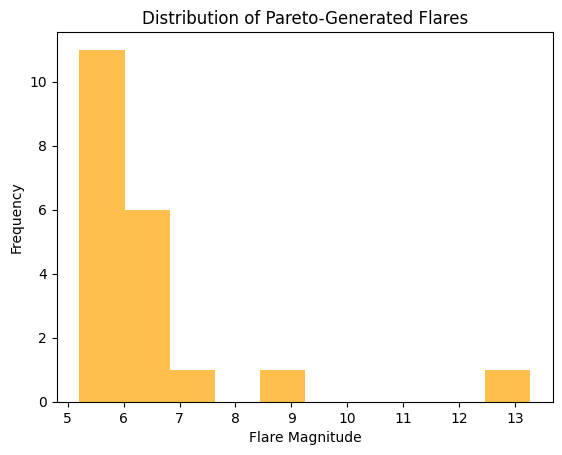

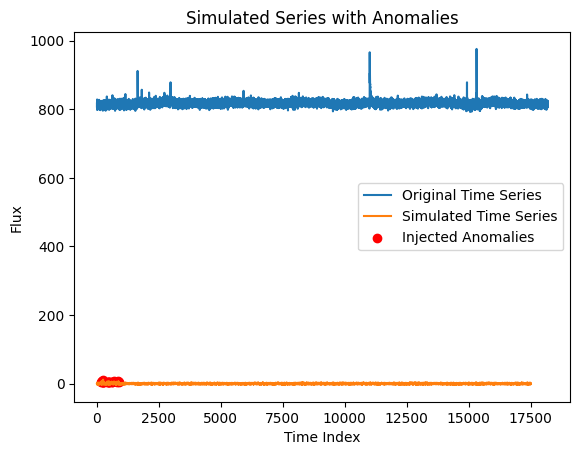

In [ ]:
## Simulate data based on ARIMA(4,1,1) and inject anomalies

# Define AR and MA coefficients based on ARIMA(4,1,1)
np.random.seed(123)
ar_coeff = [1, -0.5, 0.2, -0.3, 0.1]  # AR terms
ma_coeff = [1, -0.3]  # MA term
n = 1000

# Simulate ARIMA(4,1,1)
ar_process = ArmaProcess(ar_coeff, ma_coeff)
simulated_series = ar_process.generate_sample(nsample=n)

# Inject anomalies at random positions
n_anomalies = 20
shape_parameter = 3  # Alpha (controls tail heaviness)
scale_parameter = 5  # Scale (minimum possible value)
pareto_anomalies = (np.random.pareto(shape_parameter, n_anomalies) + 1) * scale_parameter

# Plot the distribution of anomalies
plt.hist(pareto_anomalies, bins=10, alpha=0.7, color='orange')
plt.title("Distribution of Pareto-Generated Flares")
plt.xlabel("Flare Magnitude")
plt.ylabel("Frequency")
plt.show()

anomaly_indices = np.random.randint(100, 1000, 20)

# Get median flux value of the baseline series
median_flux = np.median(simulated_series)

# Filter anomalies to remove any below the median flux
valid_anomaly_indices = []
valid_anomalies = []

for idx, val in zip(anomaly_indices, pareto_anomalies):
    if simulated_series[idx] + val > median_flux:
        valid_anomaly_indices.append(idx)
        valid_anomalies.append(val)

# Inject only valid anomalies into the series
for idx, anomaly in zip(valid_anomaly_indices, valid_anomalies):
    simulated_series[idx] += anomaly

# Plot the series with valid anomalies
# plt.plot(df['pdcsap_flux'], label="Original Time Series")
plt.plot(simulated_series, label="Simulated Time Series")
plt.scatter(valid_anomaly_indices, simulated_series[valid_anomaly_indices],
            color="red", label="Injected Anomalies")
plt.title("Simulated Series with Anomalies")
plt.xlabel("Time Index")
plt.ylabel("Flux")
plt.legend()
plt.show()

# Save valid anomalies as ground truth for evaluation
true_anomalies = set(valid_anomaly_indices)


In [ ]:
# Fit Isolation Forest on simulated data
clf_if = IsolationForest(contamination=0.01, random_state=42)
clf_if.fit(simulated_series.reshape(-1, 1))

# Get anomaly scores and predictions
anomaly_scores_if = clf_if.decision_function(simulated_series.reshape(-1, 1))
predictions_if = clf_if.predict(simulated_series.reshape(-1, 1))

# Get detected anomalies by IF (-1 indicates anomalies)
detected_anomalies_if = np.where(predictions_if == -1)[0]

# Fit DBSCAN on simulated data
dbscan = DBSCAN(eps=0.05, min_samples=10)
labels_dbscan = dbscan.fit_predict(simulated_series.reshape(-1, 1))

# Get detected anomalies by DBSCAN (-1 indicates anomalies)
detected_anomalies_dbscan = np.where(labels_dbscan == -1)[0]


In [ ]:
# Filter anomalies detected by IF to remove anomalies below the median
filtered_anomalies_if = [idx for idx in detected_anomalies_if
                         if simulated_series[idx] > median_flux]
# Filter anomalies detected by DBSCAN to remove anomalies below the median
filtered_anomalies_dbscan = [idx for idx in detected_anomalies_dbscan
                             if simulated_series[idx] > median_flux]


In [ ]:
# Define detected anomalies as sets for IF
filtered_anomalies_if_set = set(filtered_anomalies_if)

# Compute TP, FP, FN, and TN for IF
TP_if = len(true_anomalies.intersection(filtered_anomalies_if_set))
FP_if = len(filtered_anomalies_if_set - true_anomalies)
FN_if = len(true_anomalies - filtered_anomalies_if_set)
TN_if = n - (TP_if + FP_if + FN_if)

# Calculate TPR and FPR for IF
TPR_if = TP_if / (TP_if + FN_if) if (TP_if + FN_if) != 0 else 0
FPR_if = FP_if / (FP_if + TN_if) if (FP_if + TN_if) != 0 else 0

print(f"Isolation Forest (Filtered) - TPR: {TPR_if:.3f}, FPR: {FPR_if:.3f}")


Isolation Forest (Filtered) - TPR: 0.500, FPR: 0.000


In [ ]:
# Define detected anomalies as sets for DBSCAN
filtered_anomalies_dbscan_set = set(filtered_anomalies_dbscan)

# Compute TP, FP, FN, and TN for DBSCAN
TP_dbscan = len(true_anomalies.intersection(filtered_anomalies_dbscan_set))
FP_dbscan = len(filtered_anomalies_dbscan_set - true_anomalies)
FN_dbscan = len(true_anomalies - filtered_anomalies_dbscan_set)
TN_dbscan = n - (TP_dbscan + FP_dbscan + FN_dbscan)

# Calculate TPR and FPR for DBSCAN
TPR_dbscan = TP_dbscan / (TP_dbscan + FN_dbscan) if (TP_dbscan + FN_dbscan) != 0 else 0
FPR_dbscan = FP_dbscan / (FP_dbscan + TN_dbscan) if (FP_dbscan + TN_dbscan) != 0 else 0

print(f"DBSCAN (Filtered) - TPR: {TPR_dbscan:.3f}, FPR: {FPR_dbscan:.3f}")


DBSCAN (Filtered) - TPR: 1.000, FPR: 0.026


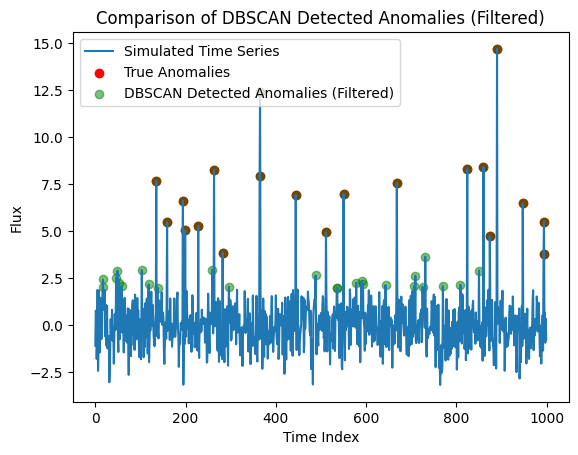

In [ ]:
# Plot the simulated series with valid and detected anomalies
plt.plot(simulated_series, label="Simulated Time Series")
plt.scatter(valid_anomaly_indices, simulated_series[valid_anomaly_indices],
            color="red", label="True Anomalies", alpha=1)
plt.scatter(filtered_anomalies_dbscan, simulated_series[filtered_anomalies_dbscan],
            color="green", label="DBSCAN Detected Anomalies (Filtered)", alpha=0.5)
plt.title("Comparison of DBSCAN Detected Anomalies (Filtered)")
plt.xlabel("Time Index")
plt.ylabel("Flux")
plt.legend()
plt.show()


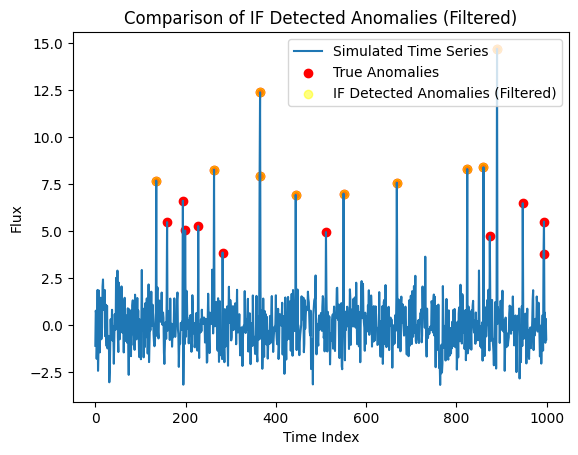

In [ ]:
# Plot the simulated series with valid and detected anomalies
plt.plot(simulated_series, label="Simulated Time Series")
plt.scatter(valid_anomaly_indices, simulated_series[valid_anomaly_indices],
            color="red", label="True Anomalies", alpha=1)
plt.scatter(filtered_anomalies_if, simulated_series[filtered_anomalies_if],
            color="yellow", label="IF Detected Anomalies (Filtered)", alpha=0.5)
plt.title("Comparison of IF Detected Anomalies (Filtered)")
plt.xlabel("Time Index")
plt.ylabel("Flux")
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Create summary DataFrame with TPR and FPR
results_df = pd.DataFrame({
    "Model": ["Isolation Forest (Filtered)", "DBSCAN (Filtered)"],
    "TPR": [TPR_if, TPR_dbscan],
    "FPR": [FPR_if, FPR_dbscan]
})

print(results_df)


                         Model  TPR      FPR
0  Isolation Forest (Filtered)  0.5  0.00000
1            DBSCAN (Filtered)  1.0  0.02551
